In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0768x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0012x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0551x4w4.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0552x4w2.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0734x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0316x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0759x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0581x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0360x4w1.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0273x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0705x4w3.png
/kaggle/input/div2k-dataset/DIV2K_train_LR_wild/DIV2K_train_LR_wild/0373x4w1.png
/kaggle/input/div2k-dataset/

In [2]:
!git clone https://github.com/oshanyalegama/WDSR.git

Cloning into 'WDSR'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 223 (delta 88), reused 2 (delta 2), pack-reused 84
Receiving objects: 100% (223/223), 13.02 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [3]:
import os
os.chdir('/kaggle/working/WDSR')

In [4]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 8

# Downgrade operator
downgrade = 'bicubic'

In [6]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

In [7]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [8]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

65753171/65753171 [==============================] - 8s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_x8_X8.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_x8_X8.cache.
3530603713/3530603713 [==============================] - 416s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
Shape of lr_img: (None, None, 3)
Shape of hr_img: (None, None, 3)
8428103/8428103 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_x8_X8.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_x8_X8.cache.
448993893/448993893 [==============================] - 38s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


In [9]:
element_spec = train_ds.element_spec

# Print the data types of elements in the dataset
for spec in element_spec:
    print("Data type:", spec.dtype)

Data type: <dtype: 'uint8'>
Data type: <dtype: 'uint8'>


In [10]:
model=wdsr_b(scale=scale, num_res_blocks=depth)
trainer = WdsrTrainer(model, 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}')

In [11]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=30000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/30000: loss = 13.459, PSNR = 24.061386 (152.03s)
2000/30000: loss = 10.697, PSNR = 24.180447 (86.59s)
3000/30000: loss = 10.354, PSNR = 24.285213 (87.10s)
4000/30000: loss = 10.186, PSNR = 24.343500 (86.23s)
5000/30000: loss = 10.193, PSNR = 24.372759 (87.10s)
6000/30000: loss = 10.078, PSNR = 24.410770 (86.75s)
7000/30000: loss = 10.077, PSNR = 24.434858 (85.87s)
8000/30000: loss = 9.964, PSNR = 24.435730 (86.21s)
9000/30000: loss = 9.980, PSNR = 24.526638 (86.69s)
10000/30000: loss = 9.940, PSNR = 24.464243 (86.29s)
11000/30000: loss = 9.886, PSNR = 24.523598 (86.16s)
12000/30000: loss = 9.828, PSNR = 24.552286 (86.40s)
13000/30000: loss = 9.796, PSNR = 24.511967 (87.18s)
14000/30000: loss = 9.860, PSNR = 24.582464 (88.48s)
15000/30000: loss = 9.784, PSNR = 24.565296 (87.82s)
16000/30000: loss = 9.776, PSNR = 24.589487 (87.65s)
17000/30000: loss = 9.750, PSNR = 24.572033 (87.69s)
18000/30000: loss = 9.708, PSNR = 24.547703 (87.62s)
19000/30000: loss = 9.659, PSNR = 24.601526 (87

In [12]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 27000.


In [13]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 23.619631


In [14]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

In [15]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [16]:
from model import resolve_single
from utils import load_image, plot_sample
from PIL import Image
import tensorflow as tf
import math

def calculate_psnr(original_path, reconstructed_path):
    # Load PNG images using PIL
    original = np.array(Image.open(original_path))
    reconstructed = np.array(Image.open(reconstructed_path))
    
    # Ensure both images have the same shape and data type
    if original.shape != reconstructed.shape:
        original_height, original_width, _ = original.shape
        reconstructed = np.array(Image.fromarray(reconstructed).resize((original_width, original_height)))
    
    
    # Calculate the Mean Squared Error (MSE) between the two images
    mse = np.mean((original - reconstructed) ** 2)
    
    # If the MSE is very close to zero, return a high PSNR value (e.g., infinity)
    if mse == 0:
        return float('inf')
    
    # Calculate the PSNR using the formula: PSNR = 10 * log10(MAX^2 / MSE)
    max_pixel_value = 255  # Assuming pixel values range from 0 to 255 (8-bit images)
    psnr = 10 * math.log10((max_pixel_value ** 2) / mse)
    
    print(tf.image.psnr(original,reconstructed, max_val=255))
    
    return psnr

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)
    sr = sr.numpy()
    sr_image = Image.fromarray(sr)
    sr_image.save('/kaggle/working/WDSR/output.png')
    

tf.Tensor(23.007572, shape=(), dtype=float32)
30.152791341242178


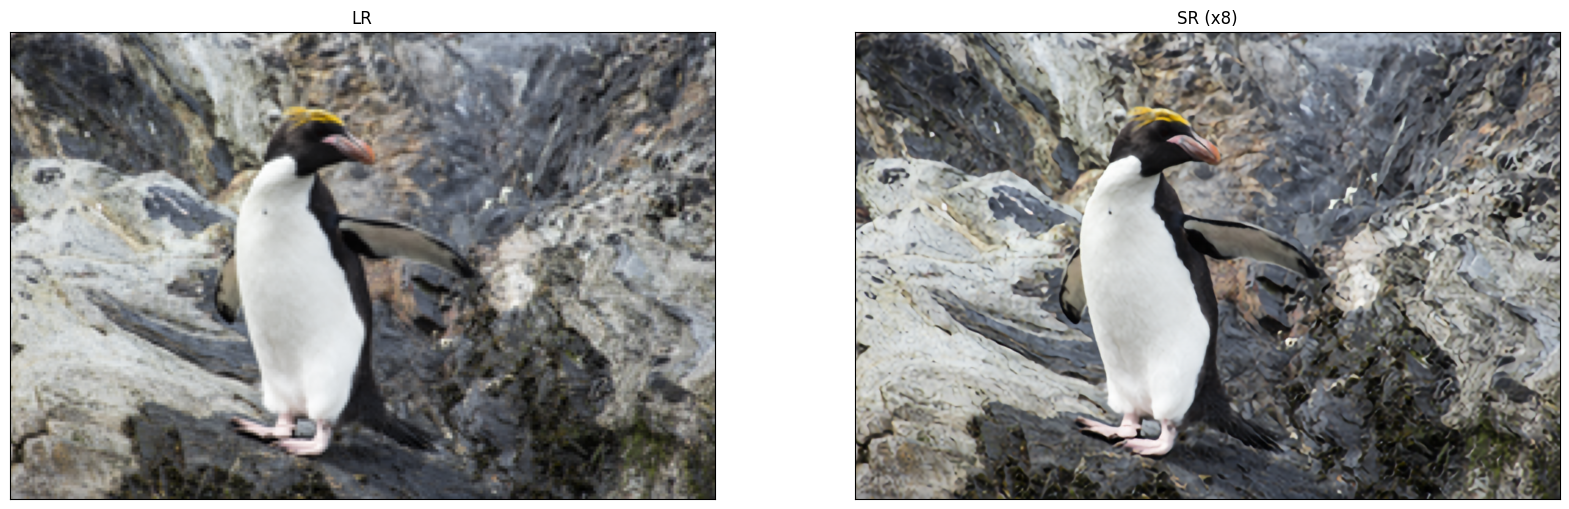

In [22]:
lr_image_path = '/kaggle/input/div2k-dataset/DIV2K_valid_LR_x8/DIV2K_valid_LR_x8/0801x8.png'
hr_image_path = '/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0801.png'
resolve_and_plot(lr_image_path)
print(calculate_psnr(hr_image_path,'/kaggle/working/WDSR/output.png'))

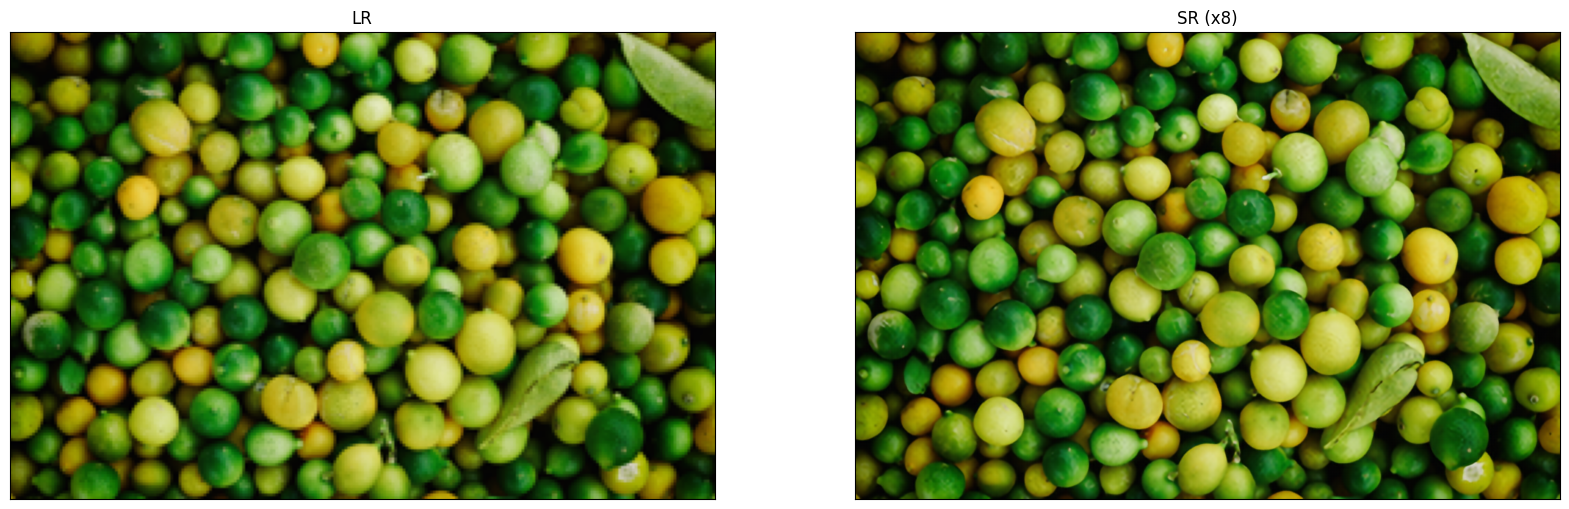

In [23]:
resolve_and_plot('/kaggle/input/div2k-dataset/DIV2K_valid_LR_x8/DIV2K_valid_LR_x8/0802x8.png')

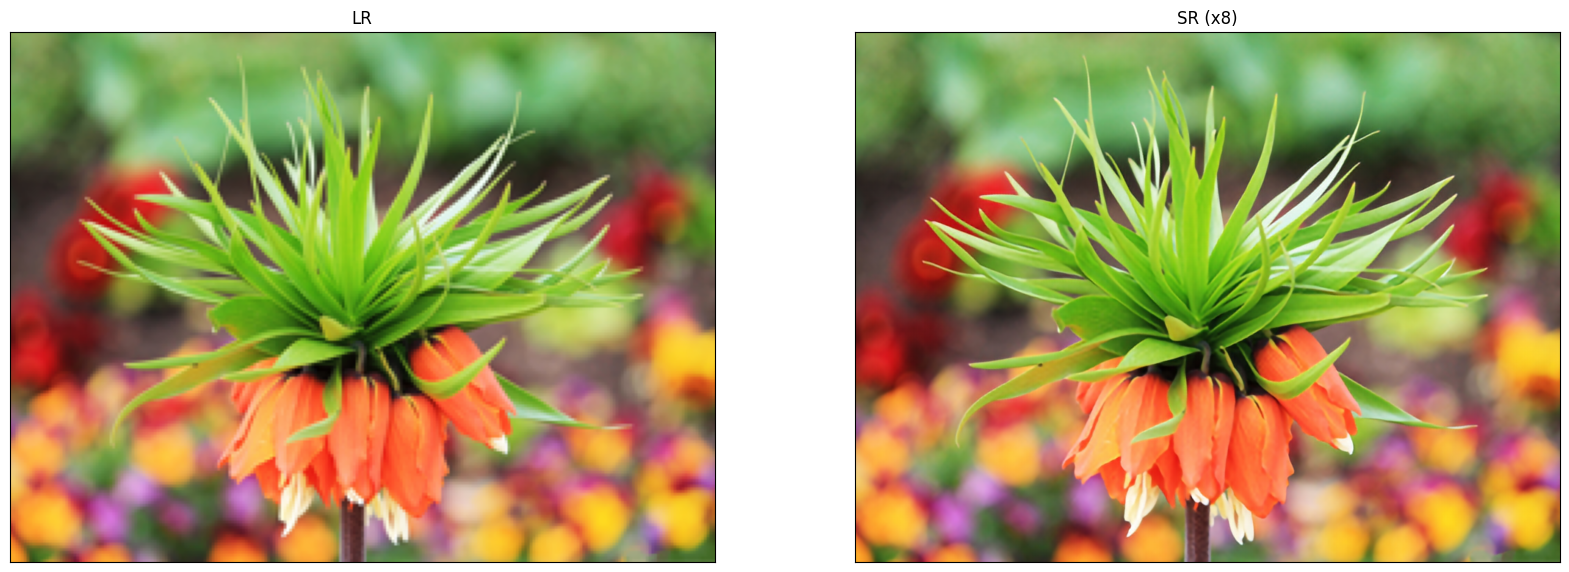

In [24]:
resolve_and_plot('/kaggle/input/div2k-dataset/DIV2K_valid_LR_x8/DIV2K_valid_LR_x8/0803x8.png')

In [20]:


calculate_psnr('/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/0801.png','')
# Example usage:
# Specify the file paths for your original and reconstructed PNG images
# original_image_path = 'original.png'
# reconstructed_image_path = 'reconstructed.png'
# Calculate PSNR
# psnr_value = calculate_psnr(original_image_path, reconstructed_image_path)
# print(f"PSNR: {psnr_value} dB")


AttributeError: 'str' object has no attribute 'read'